# Azure Machine Learning Service 

In [2]:
import azureml.core 
print(f'Ready to use AML version: {azureml.core.VERSION}')

ModuleNotFoundError: No module named 'azureml'

## Connecting to a workspace

In [2]:
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, ' has been loaded.')

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.
timer-amls  has been loaded.


In [17]:
# Get X dataset

boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [20]:
target = load_boston().target 

## Inline experiment

Starting experiment: boston-experiment
Analysing 506 rows.


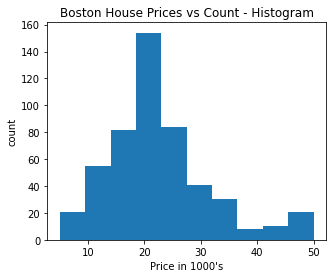

In [25]:
from azureml.core import Experiment
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.datasets import load_boston
import random
%matplotlib inline

# create experiment
experiment = Experiment(
    workspace=ws,
    name= 'boston-experiment'
)

# start logging
run = experiment.start_logging()
print(f'Starting experiment: {experiment.name}')

# load data
boston_df = pd.DataFrame(load_boston().data, columns = load_boston().feature_names)

# count rows 
boston_df_rowcount = (len(boston_df))
print(f'Analysing {boston_df_rowcount} rows.')

# log results
run.log('Observations', boston_df_rowcount)

# plot chart for target variable
boston_target = load_boston().target
fig = plt.figure(figsize=(5,4))
plt.hist(boston_target)
plt.title('Boston House Prices vs Count - Histogram')
plt.xlabel('Price in 1000\'s')
plt.ylabel('count')
plt.show()
run.log_image(name='boston house prices vs count', plot = fig)

# log average age of homeowners
avg_age = boston_df['AGE'].mean()
run.log('Average Age', avg_age)

# log random list
run.log_list('random list', (3,5,6,6,7))

# log summary stats
cols_interested = ['CRIM', 'NOX', 'DIS', 'TAX']
summary_stats = boston_df[cols_interested].describe().to_dict()
for col in summary_stats:
    keys = list(summary_stats[col].keys())
    values = list(summary_stats[col].values())
    for i in range(len(keys)):
        run.log_row(col, stat=keys[i], value=values[i])

# save a sample of the data and upload it to the experiment output folder
boston_df.sample(100).to_csv('sample.csv', index=False, header=True)
run.upload_file(name='outputs/sample.csv', path_or_stream='./sample.csv')

# complete run
run.complete()

Now lets see the results we sent to azure

In [28]:
import json 

# get details of the experiment run
details = run.get_details()
print(details)

# get logged metrics
logged_metrics = run.get_metrics()
print(json.dumps(logged_metrics, indent=2))

# get output files
files = run.get_file_names()
print(json.dumps(files, indent=2))

{'runId': '57ce113c-7ddf-4184-97be-d82a8673c36b', 'target': 'sdk', 'status': 'Completed', 'startTimeUtc': '2020-06-22T07:29:38.789955Z', 'endTimeUtc': '2020-06-22T07:29:42.098401Z', 'properties': {'ContentSnapshotId': 'ca130a01-906b-42e7-a900-6c1e300aa163'}, 'inputDatasets': [], 'logFiles': {}}
{
  "Observations": 506,
  "Average Age": 68.57490118577076,
  "boston house prices vs count": "aml://artifactId/ExperimentRun/dcid.57ce113c-7ddf-4184-97be-d82a8673c36b/boston house prices vs count_1592810979.png",
  "random list": [
    3,
    5,
    6,
    6,
    7
  ],
  "CRIM": {
    "stat": [
      "count",
      "mean",
      "std",
      "min",
      "25%",
      "50%",
      "75%",
      "max"
    ],
    "value": [
      506.0,
      3.613523557312254,
      8.60154510533249,
      0.00632,
      0.08204499999999999,
      0.25651,
      3.6770825,
      88.9762
    ]
  },
  "NOX": {
    "stat": [
      "count",
      "mean",
      "std",
      "min",
      "25%",
      "50%",
      "75%

you can also view the run with the cool interactive widget!

In [30]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

## What if you wanted to run via a script?

When running from a py file, you need to make sure you get the run context (pass it to the .py file, and get it in the py file by running Run.get_context()).

You can, just create a script, and run it using a `ScriptRunConfig`, making sure to configure a `RunConfiguration`:

- `Run Configuration`: defines the python code execution environment for the script. 
- `Script Configuration`: identifies the python script file that we want to run in the experiment, and the environment to use

In [32]:
# Lets create a folder and python script, you could do this manually
import os, shutil
folder_name = 'iris_experiment'
os.makedirs(folder_name, exist_ok=True)

UsageError: Line magic function `%%writefile` not found.


In [48]:
%%writefile $folder_name/iris_training.py
from azureml.core import Run
import pandas as pd
import os

# Get run context
run = Run.get_context()


# load data
boston_df = pd.DataFrame(load_boston().data, columns = load_boston().feature_names)

# count rows 
boston_df_rowcount = (len(boston_df))
print(f'Analysing {boston_df_rowcount} rows.')

# log results
run.log('Observations', boston_df_rowcount)

# log average age of homeowners
avg_age = boston_df['AGE'].mean()
run.log('Average Age', avg_age)

# save a sample of the data in the outputs folder
# this folder gets uploaded automatically!
os.makedirs('outputs', exist_ok=True)
boston_df.sample(100).to_csv('outputs/sample.csv', index=False, header=True)

# complete run
run.complete()

Overwriting iris_experiment/iris_training.py


Now, at this point we only have our python script defined. Now, in order to run our experiment, we need:
- `Run Configuration`: This is the execution environment for the python script. It will automatically create a conda environment
- `Script Run Configuration`: This is the config that links to the py script that we want to run, and uses the correct run configuration. Merging the script and run configs together

In [1]:
import os
import sys
from azureml.core import Experiment, RunConfiguration, ScriptRunConfig, Environment
from azureml.widgets import RunDetails
from azureml.core.environment import CondaDependencies

# create run config
experiment_run_config = RunConfiguration()
experiment_run_config.environment.python.user_managed_dependencies = True

# create script run config
script_run_config = ScriptRunConfig(
    source_directory='iris_experiment',
    script='iris_training.py',
    run_config= experiment_run_config
)
script_run_config.run_config.target = "local"

# create experiment
experiment = Experiment(ws, 'boston-experiment')

# submit experiment for a new run
run = experiment.submit(script_run_config)

# lets view it
RunDetails(run).show()

# lets wait for it to finish
run.wait_for_completion()

ModuleNotFoundError: No module named 'azureml'

# More in-depth analysis

In [34]:
%%writefile $folder_name/training_script_name.py
# import libraries
from azureml.core import Run
import pandas as pd 
import numpy as np 
import joblib 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.datasets import load_iris

# Get current Run
run = Run.get_context()

# load and split data
print('Loading data...')
iris_df = pd.DataFrame(load_iris().data, columns = load_iris().feature_names)
X = iris_df.values
y = load_iris().target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# set regularisation rate
reg = 0.01
# train model
print('training model...')
run.log('Regularisation Rate', np.float(reg))
model = LogisticRegression(C=1/reg, solver='liblinear')
model.fit(X_train, y_train)

# calculate accuracy and auc
preds = model.predict(X_test)
accuracy = np.average(preds == y_test)
print(f'The model has an accuracy of: {accuracy}')
run.log('Accuracy': np.float(accuracy))

# calculate AUC
pred_probs = model.predict_proba(X_test)
auc = roc_auc_score(y_test, pred_probs[:,1])
print(f'Model has an AUC score of: {auc}')
run.log('AUC', np.float(auc))

# save trained model
os.makedirs('outputs', exist_ok=True)
joblib.dump(value=model, filename='outputs/iris_model.pkl')

run.complete()

Overwriting iris_experiment/training_script_name.py


# Training models with a script
## First with no param, then with a param
## and registering both models

In [1]:
import os, shutil

# Create a folder for the experiment files
training_folder = 'diabetes-training'
os.makedirs(training_folder, exist_ok=True)

In [7]:
%%writefile $training_folder/diabetes_training_non-param.py
# Import libraries
from azureml.core import Run
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Get the experiment run context
run = Run.get_context()

# load the diabetes dataset
print("Loading Data...")
diabetes = pd.read_csv('diabetes.csv')

# Separate features and labels
X, y = diabetes[['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']].values, diabetes['Diabetic'].values

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Set regularization hyperparameter
reg = 0.01

# Train a logistic regression model
print('Training a logistic regression model with regularization rate of', reg)
run.log('Regularization Rate',  np.float(reg))
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)

# calculate accuracy
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)
run.log('Accuracy', np.float(acc))

# calculate AUC
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))
run.log('AUC', np.float(auc))

# Save the trained model in the outputs folder
os.makedirs('outputs', exist_ok=True)
joblib.dump(value=model, filename='outputs/diabetes_model.pkl')

run.complete()

Writing diabetes-training/diabetes_training_non-param.py


You can either:
- Run an experiment using a `RunConfiguration` + `ScriptRunConfiguration`
- Estimator

An estimator abstracts both the run config and the script run config. 

In [10]:
from azureml.train.estimator import Estimator
from azureml.core import Experiment, Environment

myenv = Environment(name='myenv')
myenv.build_local(workspace=ws,)

estimator = Estimator(
    source_directory=training_folder,
    entry_script='diabetes_training_non-param.py',
    compute_target='local',
    environment_definition=myenv
)

experiment_name = 'diabetes-training-non-param'
experiment = Experiment(ws, experiment_name)
run = experiment.submit(config=estimator)
run.wait_for_completion(show_output=True)

RunId: diabetes-training-non-param_1592835294_736ef7e9
Web View: https://ml.azure.com/experiments/diabetes-training-non-param/runs/diabetes-training-non-param_1592835294_736ef7e9?wsid=/subscriptions/85b036b3-e3ba-4991-9831-e96a1bdd3119/resourcegroups/timer-rg/workspaces/timer-amls

Streaming azureml-logs/60_control_log.txt

Streaming log file azureml-logs/60_control_log.txt
Running: ['/bin/bash', '/private/var/folders/15/rywl4gy907v5xw94jqxlfxmh0000gn/T/azureml_runs/diabetes-training-non-param_1592835294_736ef7e9/azureml-environment-setup/conda_env_checker.sh']
Starting the daemon thread to refresh tokens in background for process with pid = 16464
Materialized conda environment not found on target: /Users/abditimer/.azureml/envs/azureml_da3e97fcb51801118b8e80207f3e01ad


Logging experiment preparation status in history service.
Running: ['/bin/bash', '/private/var/folders/15/rywl4gy907v5xw94jqxlfxmh0000gn/T/azureml_runs/diabetes-training-non-param_1592835294_736ef7e9/azureml-environmen

ActivityFailedException: ActivityFailedException:
	Message: Activity Failed:
{
    "error": {
        "code": "UserError",
        "message": "Unable to run conda package manager. AzureML uses conda to provision python\nenvironments from a dependency specification. To manage the python environment\nmanually instead, set userManagedDependencies to True in the python environment\nconfiguration. To use system managed python environments, install conda from:\nhttps://conda.io/miniconda.html",
        "details": [],
        "messageParameters": {}
    },
    "time": "2020-06-22T14:14:56.963807Z"
}
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Activity Failed:\n{\n    \"error\": {\n        \"code\": \"UserError\",\n        \"message\": \"Unable to run conda package manager. AzureML uses conda to provision python\\nenvironments from a dependency specification. To manage the python environment\\nmanually instead, set userManagedDependencies to True in the python environment\\nconfiguration. To use system managed python environments, install conda from:\\nhttps://conda.io/miniconda.html\",\n        \"details\": [],\n        \"messageParameters\": {}\n    },\n    \"time\": \"2020-06-22T14:14:56.963807Z\"\n}"
    }
}